# LAB

In [1]:
import os

opencv_path = "/Users/ostapbodnar/.virtualenvs/cv-2023/lib/python3.9/site-packages"
if opencv_path not in os.sys.path:
    os.sys.path.append(opencv_path)

In [2]:
import numpy as np
import scipy.spatial.distance as sd
import cv2 as cv
import matplotlib.pyplot as plt

In [3]:
img1 = cv.imread('images/original_1.png', cv.IMREAD_GRAYSCALE)  # queryImage
img2 = cv.imread('images/disturbed_1.png', cv.IMREAD_GRAYSCALE)  # trainImage
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)


def open_cv_brute_force_match_descriptors():
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])

    img3 = cv.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img3), plt.show()

In [9]:
def match_descriptors(desc1, desc2, threshold=0.85):
    dists = sd.cdist(desc1, desc2)

    indices1 = np.argsort(dists, axis=1)[:, :2]
    distances1 = dists[np.arange(len(indices1))[:, np.newaxis], indices1]

    indices2 = np.argmin(dists, axis=1)
    distances2 = dists[np.arange(len(indices2)), indices2]

    ratios = distances1[:, 0] / distances1[:, 1]

    mask = ratios < threshold
    matches = [[cv.DMatch(i, indices1[i, 0], distances1[i, 0])]
               for i in range(len(indices1))
               if mask[i] and distances2[indices1[i, 0]] < threshold * distances2[i]]

    img3 = cv.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img3), plt.show()



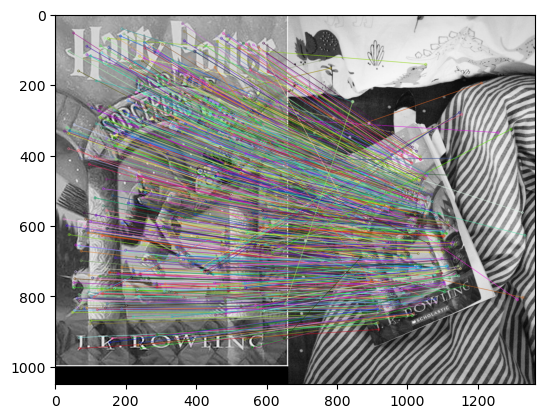

In [ ]:
open_cv_brute_force_match_descriptors()

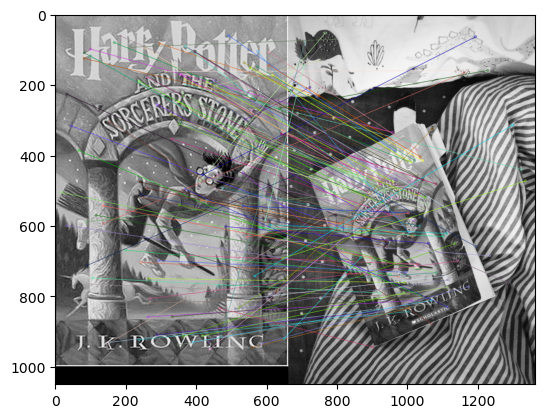

In [15]:
match_descriptors(des1, des2, threshold=0.85)

# Ransac

In [16]:



def ransac_match(keypoints1, descriptors1, keypoints2, descriptors2, threshold=0.7, ransac_reproj_thresh=3.0,
                 ransac_iter=1000):
    """Match keypoints using RANSAC algorithm with homography matrix."""

    # Create a Brute Force Matcher object and compute the matches
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)

    # Convert keypoints to numpy arrays
    pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 2)
    pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 2)

    # Initialize variables to keep track of best matches and inlier count
    best_matches, H_ = [], None
    max_inliers = 0

    # Loop through RANSAC iterations
    for i in range(ransac_iter):

        # Choose random 4 points
        idx = np.random.choice(pts1.shape[0], 4, replace=False)
        src_pts = np.float32([pts1[idx[0]], pts1[idx[1]], pts1[idx[2]], pts1[idx[3]]])
        dst_pts = np.float32([pts2[idx[0]], pts2[idx[1]], pts2[idx[2]], pts2[idx[3]]])

        # Compute homography matrix
        H, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC, ransac_reproj_thresh)

        # Apply homography to all points in pts1 and compare to pts2
        transformed_pts = cv.perspectiveTransform(pts1.reshape(-1, 1, 2), H)
        distances = np.linalg.norm(pts2 - transformed_pts.reshape(-1, 2), axis=1)
        inliers = np.where(distances < threshold)[0]

        # Update best matches and inlier count
        if len(inliers) > max_inliers:
            H_ = H
            max_inliers = len(inliers)
            best_matches = [matches[i] for i in inliers]

    return H_, best_matches


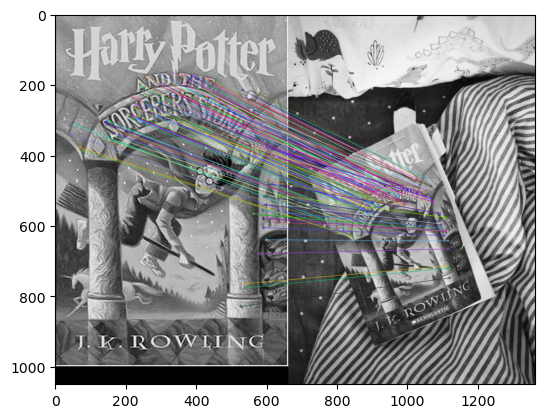

array([[ 3.96575737e-01,  1.42023129e-01,  8.90873282e+01],
       [-2.17606933e-01,  3.80354572e-01,  4.80076313e+02],
       [-3.99892099e-05, -8.37384462e-05,  1.00000000e+00]])

In [20]:
H, matches = ransac_match(kp1, des1, kp2, des2)

img3 = cv.drawMatchesKnn(img1, kp1, img2, kp2, [[m] for m in matches], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3), plt.show()
H

# GLOH